Test implementation of a Variational Autoencoder

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers, losses

from keras.datasets import mnist
from keras.models import Model

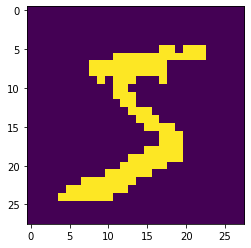

In [69]:
(x_train, _), (x_test, y_test) = mnist.load_data()

def preprocess_images(images, discrete=True):
    # Normalize and make into tensor
    images = images.reshape((images.shape[0], 28, 28, 1)) /255.

    if discrete:
        # Round pixel values to 0 or 1. Allows use of cross entropy loss?
        return np.where(images > .5, 1.0, 0.0).astype('float32')
    else:
        # No discretization of pixel values
        return images.astype('float32')

x_train = preprocess_images(x_train)
x_test = preprocess_images(x_test)

# shape: (nbr_images, 28, 28, 1)

# Look at image 1
plt.imshow(x_train[0, :, :, 0])
plt.show()

In [77]:

# Do we need to batch and shuffle the data?
# Maybe in we dont use the fit() function, we need to do it manually

train_size = x_train.shape[0]
batch_size = 32 # Size of batches in gradient update / training step?
test_size = x_test.shape[0]
print(x_test.shape)

train_dataset = (tf.data.Dataset.from_tensor_slices(x_train).shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(x_test).shuffle(test_size).batch(batch_size))

print(test_dataset)

(10000, 28, 28, 1)
<BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>


Alternative functional approach

https://keras.io/examples/generative/vae/


In [60]:
# Define model
# https://www.tensorflow.org/tutorials/generative/cvae

class VAE(Model):
    def __init__(self, latent_dim=2):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        self.encoder = keras.Sequential([
            layers.InputLayer(input_shape=(28, 28, 1)),

            layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            layers.Flatten(),

            # 2D latent space -> 2D mean, 2D var ->
            # mean1, mean2, log_var1, log_var2 -> 2 + 2
            layers.Dense(latent_dim + latent_dim),
        ])

        self.decoder = keras.Sequential([
            # Point z sampled from distrs. will be 2D
            layers.InputLayer(input_shape=(latent_dim,)),

            # BIG dense that takes 2d z input
            layers.Dense(units=7*7*32, activation='relu'),

            # Reshape into tensor
            layers.Reshape(target_shape=(7, 7, 32)),

            # Transp. Conv: padding same? no upsampling?
            # Pads the input so output is same dim?
            layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=(2, 2), padding='same',
                activation='relu'),
            layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=(2, 2), padding='same',
                activation='relu'),

            # Last layer, no activation / linear?
            layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=(1, 1), padding='same'),
        ])

    # Decorator: turns py code into graph
    # Use for computationally expensive functions
    @tf.function
    def sample(self, eps=None):
        # Sample 100 random z?
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)
    
    def encode(self, x):
        mean, logvar = tf.split(
            self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        # Returns a z sampled from N(mean, var)
        eps = tf.random.normal(shape=mean.shape)
        return mean + eps * tf.exp(logvar * .5) # mu + eps * std

    def decode(self, z, apply_sigmoid=False):
        # Decode latent z into image
        # apply_sigmoid: outputs pixel values [0, 1]
        logits = self.decoder(z) # logits vals: (-inf, inf)?
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

    # Is this even needed?
    def call(self, x):
        mean, logvar = self.encode(x)
        sampled_z = self.reparameterize(mean, logvar)
        decoded_img = self.decode(sampled_z)
        return decoded_img


In [78]:
# Defining loss function

# learning rate: 1e-4
optimizer = tf.keras.optimizers.Adam(1e-4)

# Returns logarithm of normal pdf w. 
# mean, logvar for each value in 'sample'
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)

    # log(norm_pdf(sample; mean, var))
    values = -.5 * (logvar + log2pi + 
    (sample - mean)**2 * tf.exp(-logvar))

    # 'values' consists of log pdf in both latent x- and y-directions
    # 'reduce_sum' sums these up to one value
    return tf.reduce_sum(values, axis=raxis)


def compute_loss(model, x):
    # Compute ELBO loss w.r.t a sample x (or batch?)
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)

    # Loss between input & output (reconstruction). Binary cross entropy
    # indep. for each pixel?
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(
        logits=x_logit, labels=x)
    
    log_px_z = -tf.reduce_sum(cross_ent, axis=[1,2,3])
    log_pz = log_normal_pdf(z, 0., 0.)
    log_qz_x = log_normal_pdf(z, mean, logvar)

    # 'mean' to approx. expectation
    return -tf.reduce_mean(log_px_z + log_p - log_qz_x)


@tf.function
def train_step(model, x, optimizer):
    # Computes gradients and updates weights

    # TODO: learn how gradient tape works
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))




In [79]:
vae = VAE()
mean, logvar = vae.encode(x_test)
z = vae.reparameterize(mean, logvar)
lognorm = log_normal_pdf(z[:32], 0., 0.)
print(lognorm)


tf.Tensor(
[-2.1392515 -2.295099  -2.4065928 -1.9226097 -2.7018957 -1.9563621
 -1.8585243 -2.9618683 -3.475165  -2.1854844 -2.38395   -2.4107065
 -5.2904415 -1.9870112 -2.7471642 -4.691511  -2.9410663 -2.8098855
 -2.2407205 -4.683412  -2.3597426 -4.041474  -2.6476479 -2.4794314
 -1.8529975 -4.3969474 -1.9713879 -2.1875005 -2.4826577 -7.1136003
 -3.2111735 -1.9316564], shape=(32,), dtype=float32)
